# Some try to match a corr matrix

In [1]:
import numpy as np
import torch

In [2]:
import scanpy as sc
import decoupler as dc
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/other_celltypes")
os.chdir(root_dir)

## Astrocytes

In [4]:
celltype = "Astro"
rna_counts = sc.read_h5ad(f"{celltype}_rna_matrix.h5ad")
if rna_counts.raw is not None:
    rna_counts = rna_counts.raw.to_adata()
rna_region_counts = dc.get_pseudobulk(
    adata=rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(rna_region_counts, target_sum=1e6)
sc.pp.log1p(rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
raw_counts = rna_region_counts[region_align, :].X.copy()

/tscc/nfs/home/biy022/miniconda3/envs/finemo/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
target_corr_mat = np.array([
    [1,-0.0477563379724213,0.525523921070503,-0.163949941876798,0.538885954911289,0.440104369994919,-0.321772416574859,-0.0294798949101458,-0.268502429900736],
    [-0.0477563379724213,1,-0.173177624851364,0.54335734186835,0.248099309941532,-0.0331245205134547,0.133505603649451,0.326408577615984,0.601098922931271],
    [0.525523921070503,-0.173177624851364,1,-0.516401748364086,0.410056616200542,0.597699868507704,-0.477231765355664,-0.323365103842049,-0.455270455823676],
    [-0.163949941876798,0.54335734186835,-0.516401748364086,1,0.280596550125281,-0.187089236625696,0.696849929042799,0.786751866741219,0.638521408139612],
    [0.538885954911289,0.248099309941532,0.410056616200542,0.280596550125281,1,0.403908161154982,0.167754477385837,0.343856658497548,0.248604407081287],
    [0.440104369994919,-0.0331245205134547,0.597699868507704,-0.187089236625696,0.403908161154982,1,-0.348167080892437,-0.252873978747433,-0.294340151990306],
    [-0.321772416574859,0.133505603649451,-0.477231765355664,0.696849929042799,0.167754477385837,-0.348167080892437,1,0.443986840305315,0.410597901315342],
    [-0.0294798949101458,0.326408577615984,-0.323365103842049,0.786751866741219,0.343856658497548,-0.252873978747433,0.443986840305315,1,0.418118738024369],
    [-0.268502429900736,0.601098922931271,-0.455270455823676,0.638521408139612,0.248604407081287,-0.294340151990306,0.410597901315342,0.418118738024369,1],
])

In [8]:
Z = torch.randn(raw_counts.shape[1], requires_grad=True)
optimizer = torch.optim.Adam([Z], lr=0.005)

def loss_fn(Z, A, T_target):
    X = torch.sigmoid(Z)
    B = A * X
    T_B = torch.corrcoef(B)
    return torch.norm(T_B - T_target, "fro")

In [9]:
for i in range(100000):
    optimizer.zero_grad()
    loss = loss_fn(
        Z, 
        torch.tensor(raw_counts, dtype=torch.float32), 
        torch.tensor(target_corr_mat, dtype=torch.float32)
    )
    loss.backward()
    optimizer.step()
    
    if i % 10000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 7.892734527587891
Iteration 10000, Loss: 1.3785433769226074
Iteration 20000, Loss: 1.237788200378418
Iteration 30000, Loss: 1.237697720527649
Iteration 40000, Loss: 1.2376981973648071
Iteration 50000, Loss: 1.2376351356506348
Iteration 60000, Loss: 1.2376291751861572
Iteration 70000, Loss: 1.2376291751861572
Iteration 80000, Loss: 1.2376291751861572
Iteration 90000, Loss: 1.2376291751861572


<Axes: ylabel='Density'>

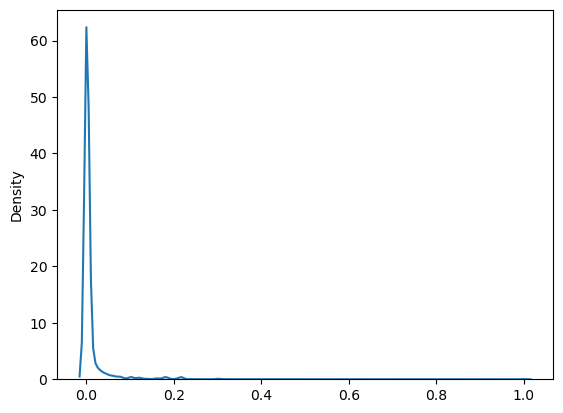

In [10]:
X_opt = torch.sigmoid(Z).detach().numpy()
sns.kdeplot(X_opt)

(9, 23)


<Axes: >

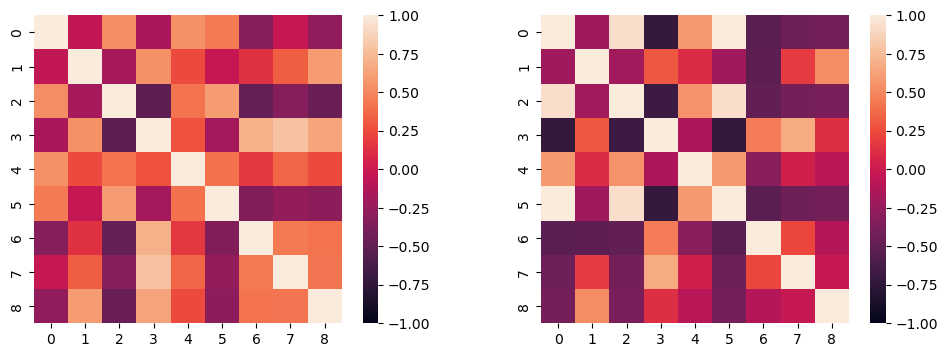

In [18]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(target_corr_mat, ax=ax1, square=True, vmin=-1, vmax=1)
B = raw_counts[:, X_opt > 0.5]
print(B.shape)
result = np.corrcoef(B)
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(result, ax=ax2, square=True, vmin=-1, vmax=1)

In [10]:
target_corr_mat = np.array([
    [1,0.394856232160633,0.900935266032261,-0.0209812628159742,0.763570511078491,0.619264164111147,0.031276085397561,0.251689807180251,-0.371676617140762],
    [0.394856232160633,1,0.169066315843232,0.567504518848343,0.278941450542378,-0.0590078173865665,0.479318320388075,0.847199056644689,0.395640050562899],
    [0.900935266032261,0.169066315843232,1,-0.434232513822471,0.589011456045809,0.821239631019036,-0.379539761510051,-0.12343305729556,-0.639032105111875],
    [-0.0209812628159742,0.567504518848343,-0.434232513822471,1,0.140177243374065,-0.642899247239424,0.960214995730711,0.871255484165532,0.789031831758112],
    [0.763570511078491,0.278941450542378,0.589011456045809,0.140177243374065,1,0.596777655011321,0.269995959815688,0.258379402969023,-0.330339253357229],
    [0.619264164111147,-0.0590078173865665,0.821239631019036,-0.642899247239424,0.596777655011321,1,-0.584573382435871,-0.434887338921835,-0.893788872737625],
    [0.031276085397561,0.479318320388075,-0.379539761510051,0.960214995730711,0.269995959815688,-0.584573382435871,1,0.833613469714529,0.777477390188682],
    [0.251689807180251,0.847199056644689,-0.12343305729556,0.871255484165532,0.258379402969023,-0.434887338921835,0.833613469714529,1,0.713635347857785],
    [-0.371676617140762,0.395640050562899,-0.639032105111875,0.789031831758112,-0.330339253357229,-0.893788872737625,0.777477390188682,0.713635347857785,1],
])

In [11]:
Z = torch.randn(raw_counts.shape[1], requires_grad=True)
optimizer = torch.optim.Adam([Z], lr=0.01)

def loss_fn(Z, A, T_target):
    X = torch.sigmoid(Z)
    B = A * X
    T_B = torch.corrcoef(B)
    return torch.norm(T_B - T_target, "fro")
for i in range(20000):
    optimizer.zero_grad()
    loss = loss_fn(
        Z, 
        torch.tensor(raw_counts, dtype=torch.float32), 
        torch.tensor(target_corr_mat, dtype=torch.float32)
    )
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 7.864321708679199
Iteration 1000, Loss: 4.699090480804443
Iteration 2000, Loss: 3.5222666263580322
Iteration 3000, Loss: 3.044034957885742
Iteration 4000, Loss: 2.7492752075195312
Iteration 5000, Loss: 2.5854203701019287
Iteration 6000, Loss: 2.4748799800872803
Iteration 7000, Loss: 2.407283067703247
Iteration 8000, Loss: 2.3684511184692383
Iteration 9000, Loss: 2.3327980041503906
Iteration 10000, Loss: 2.3052279949188232
Iteration 11000, Loss: 2.2959072589874268
Iteration 12000, Loss: 2.2957637310028076
Iteration 13000, Loss: 2.2957606315612793
Iteration 14000, Loss: 2.295759439468384
Iteration 15000, Loss: 2.2957582473754883
Iteration 16000, Loss: 2.2957582473754883
Iteration 17000, Loss: 2.29575777053833
Iteration 18000, Loss: 2.29575777053833
Iteration 19000, Loss: 2.2957582473754883


<Axes: ylabel='Density'>

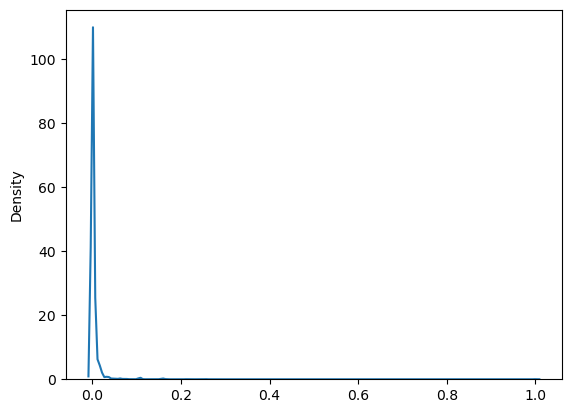

In [12]:
X_opt = torch.sigmoid(Z).detach().numpy()
sns.kdeplot(X_opt)

(9, 12)


<Axes: >

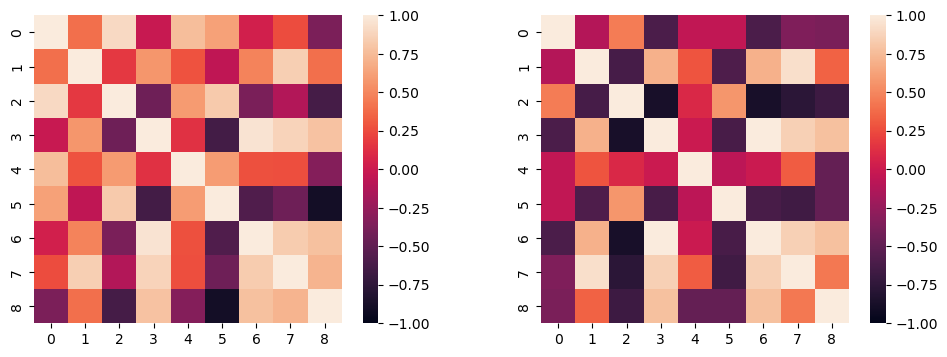

In [13]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(target_corr_mat, ax=ax1, square=True, vmin=-1, vmax=1)
B = raw_counts[:, X_opt > 0.5]
print(B.shape)
result = np.corrcoef(B)
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(result, ax=ax2, square=True, vmin=-1, vmax=1)

## L2/3 IT

In [19]:
celltype = "L2_3_IT"
rna_counts = sc.read_h5ad(f"{celltype}_rna_matrix.h5ad")
if rna_counts.raw is not None:
    rna_counts = rna_counts.raw.to_adata()
rna_region_counts = dc.get_pseudobulk(
    adata=rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(rna_region_counts, target_sum=1e6)
sc.pp.log1p(rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
raw_counts = rna_region_counts[region_align, :].X.copy()

/tscc/nfs/home/biy022/miniconda3/envs/finemo/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
target_corr_mat = np.array([
    [1,0.883044099843332,0.721459183061701,0.794715927961463,0.748747081206719,0.66939771544504,0.775686190271696,0.835702552081961,0.760135291239455],
    [0.883044099843332,1,0.83072965561328,0.805715037781131,0.636545620241836,0.776517952079455,0.713573159850172,0.899102921973653,0.778714927840962],
    [0.721459183061701,0.83072965561328,1,0.732409649857523,0.675138071197081,0.87430763927178,0.742967408449887,0.923372849427871,0.740664787587536],
    [0.794715927961463,0.805715037781131,0.732409649857523,1,0.711107568676242,0.641480156224853,0.873566560308273,0.803930074046558,0.91846502565562],
    [0.748747081206719,0.636545620241836,0.675138071197081,0.711107568676242,1,0.545456879024877,0.783784377609343,0.675942169682257,0.698234662761269],
    [0.66939771544504,0.776517952079455,0.87430763927178,0.641480156224853,0.545456879024877,1,0.65487507848436,0.892399711810839,0.641712626390082],
    [0.775686190271696,0.713573159850172,0.742967408449887,0.873566560308273,0.783784377609343,0.65487507848436,1,0.826003615317594,0.882406629707588],
    [0.835702552081961,0.899102921973653,0.923372849427871,0.803930074046558,0.675942169682257,0.892399711810839,0.826003615317594,1,0.802201770116069],
    [0.760135291239455,0.778714927840962,0.740664787587536,0.91846502565562,0.698234662761269,0.641712626390082,0.882406629707588,0.802201770116069,1],
])

In [21]:
Z = torch.randn(raw_counts.shape[1], requires_grad=True)
optimizer = torch.optim.Adam([Z], lr=0.01)

def loss_fn(Z, A, T_target):
    X = torch.sigmoid(Z)
    B = A * X
    T_B = torch.corrcoef(B)
    return torch.norm(T_B - T_target, "fro")
for i in range(20000):
    optimizer.zero_grad()
    loss = loss_fn(
        Z, 
        torch.tensor(raw_counts, dtype=torch.float32), 
        torch.tensor(target_corr_mat, dtype=torch.float32)
    )
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 2.065643787384033
Iteration 1000, Loss: 0.6521351933479309
Iteration 2000, Loss: 0.34560829401016235
Iteration 3000, Loss: 0.23533761501312256
Iteration 4000, Loss: 0.1512383073568344
Iteration 5000, Loss: 0.10005045682191849
Iteration 6000, Loss: 0.0784357562661171
Iteration 7000, Loss: 0.038762129843235016
Iteration 8000, Loss: 0.006939609069377184
Iteration 9000, Loss: 0.00043727774755097926
Iteration 10000, Loss: 0.0004465198435354978
Iteration 11000, Loss: 0.0003922901232726872
Iteration 12000, Loss: 0.00036782282404601574
Iteration 13000, Loss: 0.0004102528910152614
Iteration 14000, Loss: 0.000449770042905584
Iteration 15000, Loss: 0.00043832804658450186
Iteration 16000, Loss: 0.000476709334179759
Iteration 17000, Loss: 0.0004517200286500156
Iteration 18000, Loss: 0.0004664694133680314
Iteration 19000, Loss: 0.00044872573926113546


<Axes: ylabel='Density'>

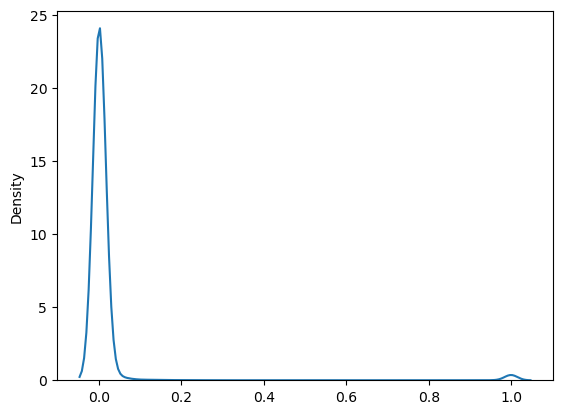

In [22]:
X_opt = torch.sigmoid(Z).detach().numpy()
sns.kdeplot(X_opt)

(9, 544)


<Axes: >

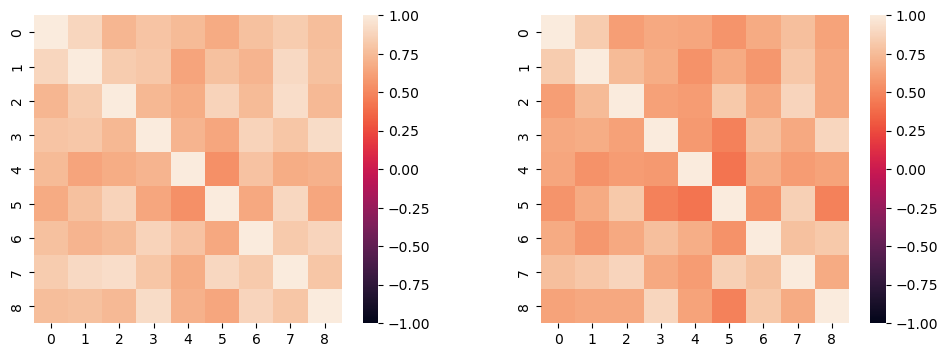

In [23]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(target_corr_mat, ax=ax1, square=True, vmin=-1, vmax=1)
B = raw_counts[:, X_opt > 0.5]
print(B.shape)
result = np.corrcoef(B)
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(result, ax=ax2, square=True, vmin=-1, vmax=1)

In [26]:
from matplotlib_venn import venn2
import pandas as pd

In [28]:
regional_degs = dict()
region_order = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
deg_dir = Path("../../regional_dar_deg/deg/")
for region in region_order:
    deg_table = pd.read_csv(deg_dir / celltype / "{}_result.tsv".format(region), sep="\t", header=0, index_col=0)
    deg_sig_list = deg_table[(deg_table["logFC"] > 0) & (deg_table["FDR"] < 0.001)].index.to_list()
    regional_degs[region] = deg_sig_list

In [37]:
corr_selected_genes = rna_region_counts.var.index[X_opt > 0.5].to_list()

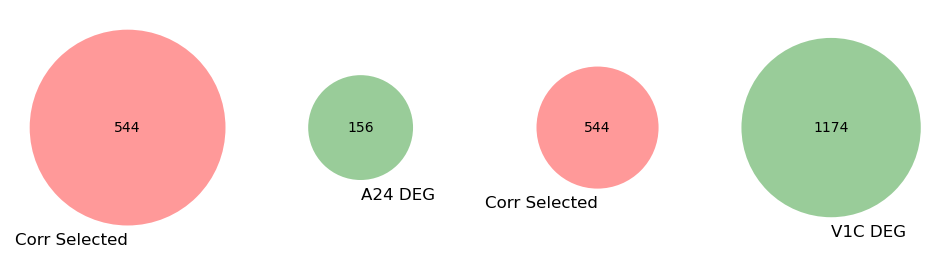

In [39]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
venn2(
    [set(corr_selected_genes), set(regional_degs["A24"])], 
    set_labels=("Corr Selected", "A24 DEG"), 
    ax=ax1
)
ax2 = fig.add_subplot(gs[0, 1])
venn2(
    [set(corr_selected_genes), set(regional_degs["V1C"])], 
    set_labels=("Corr Selected", "V1C DEG"), 
    ax=ax2
)

In [19]:
target_corr_mat = np.array([
    [1,0.860763708265697,0.457231200932396,0.930439146792128,0.699136302291983,0.564600253149548,0.813743762445643,0.678540663328645,0.666971138399182],
    [0.860763708265697,1,0.808123995334152,0.98025031560194,0.951116464772272,0.867488335472885,0.916674750511615,0.838895466762595,0.917214852363246],
    [0.457231200932396,0.808123995334152,1,0.73281818085952,0.937003503258797,0.990266060786418,0.846025804584184,0.884471439467938,0.959546577442205],
    [0.930439146792128,0.98025031560194,0.73281818085952,1,0.90634795499483,0.811082592644863,0.934938217314636,0.836011456175919,0.880918209339904],
    [0.699136302291983,0.951116464772272,0.937003503258797,0.90634795499483,1,0.968956298078889,0.933096947201883,0.919539967867016,0.973776439354884],
    [0.564600253149548,0.867488335472885,0.990266060786418,0.811082592644863,0.968956298078889,1,0.908030684025974,0.927296966372622,0.983725515226248],
    [0.813743762445643,0.916674750511615,0.846025804584184,0.934938217314636,0.933096947201883,0.908030684025974,1,0.9668486955116,0.938786014000433],
    [0.678540663328645,0.838895466762595,0.884471439467938,0.836011456175919,0.919539967867016,0.927296966372622,0.9668486955116,1,0.914295847455825],
    [0.666971138399182,0.917214852363246,0.959546577442205,0.880918209339904,0.973776439354884,0.983725515226248,0.938786014000433,0.914295847455825,1],
])

In [20]:
Z = torch.randn(raw_counts.shape[1], requires_grad=True)
optimizer = torch.optim.Adam([Z], lr=0.01)

def loss_fn(Z, A, T_target):
    X = torch.sigmoid(Z)
    B = A * X
    T_B = torch.corrcoef(B)
    return torch.norm(T_B - T_target, "fro")
for i in range(20000):
    optimizer.zero_grad()
    loss = loss_fn(
        Z, 
        torch.tensor(raw_counts, dtype=torch.float32), 
        torch.tensor(target_corr_mat, dtype=torch.float32)
    )
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 1.5067970752716064
Iteration 1000, Loss: 0.7125013470649719
Iteration 2000, Loss: 0.5417124032974243
Iteration 3000, Loss: 0.43611812591552734
Iteration 4000, Loss: 0.40419888496398926
Iteration 5000, Loss: 0.3326907753944397
Iteration 6000, Loss: 0.26456475257873535
Iteration 7000, Loss: 0.21177318692207336
Iteration 8000, Loss: 0.18965868651866913
Iteration 9000, Loss: 0.15570038557052612
Iteration 10000, Loss: 0.1457599699497223
Iteration 11000, Loss: 0.11932018399238586
Iteration 12000, Loss: 0.09814547747373581
Iteration 13000, Loss: 0.0837564766407013
Iteration 14000, Loss: 0.08059006184339523
Iteration 15000, Loss: 0.0787544846534729
Iteration 16000, Loss: 0.0787079930305481
Iteration 17000, Loss: 0.07870177924633026
Iteration 18000, Loss: 0.0786995217204094
Iteration 19000, Loss: 0.07866016030311584


<Axes: ylabel='Density'>

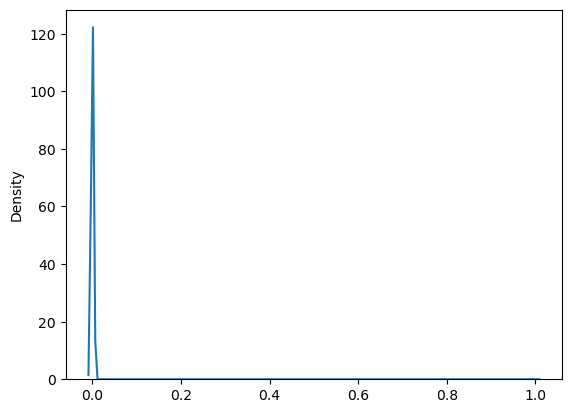

In [21]:
X_opt = torch.sigmoid(Z).detach().numpy()
sns.kdeplot(X_opt)

(9, 23)


<Axes: >

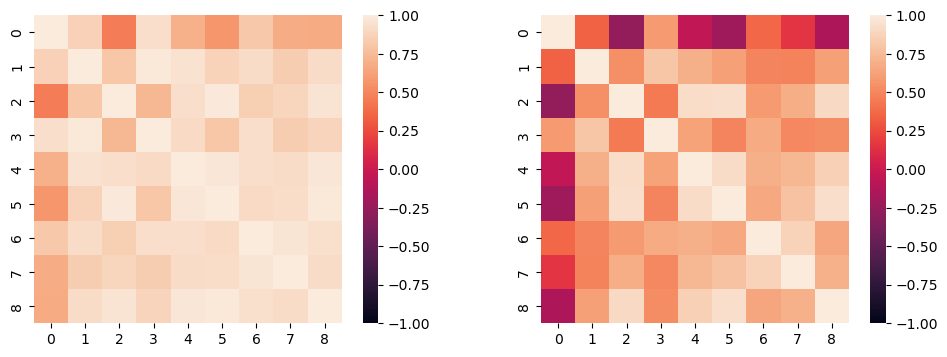

In [22]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(target_corr_mat, ax=ax1, square=True, vmin=-1, vmax=1)
B = raw_counts[:, X_opt > 0.5]
print(B.shape)
result = np.corrcoef(B)
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(result, ax=ax2, square=True, vmin=-1, vmax=1)

## L4 IT

In [23]:
celltype = "L4_IT"
rna_counts = sc.read_h5ad(f"{celltype}_rna_matrix.h5ad")
if rna_counts.raw is not None:
    rna_counts = rna_counts.raw.to_adata()
rna_region_counts = dc.get_pseudobulk(
    adata=rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(rna_region_counts, target_sum=1e6)
sc.pp.log1p(rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
raw_counts = rna_region_counts[region_align, :].X.copy()

/tscc/nfs/home/biy022/miniconda3/envs/finemo/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [24]:
target_corr_mat = np.array([
    [1,0.683225486692303,0.654797138114871,0.698499168999853,0.552759210523822,0.244368621112615,0.523206978789982,0.446186134249846,0.654196830995212],
    [0.683225486692303,1,0.734126463108935,0.762035537095138,0.810153108725582,0.526198458823728,0.610183202962903,0.568117714184238,0.570104503021604],
    [0.654797138114871,0.734126463108935,1,0.671610827379431,0.645056480508249,0.701832207008025,0.833796582874023,0.917873568973684,0.485540171617904],
    [0.698499168999853,0.762035537095138,0.671610827379431,1,0.700652159715104,0.358276568835939,0.798377006554986,0.543005088546506,0.613745219709906],
    [0.552759210523822,0.810153108725582,0.645056480508249,0.700652159715104,1,0.700165492415676,0.509891856903681,0.488979739846757,0.458841625444483],
    [0.244368621112615,0.526198458823728,0.701832207008025,0.358276568835939,0.700165492415676,1,0.522851294388186,0.642612735274403,0.208874521730765],
    [0.523206978789982,0.610183202962903,0.833796582874023,0.798377006554986,0.509891856903681,0.522851294388186,1,0.841924426737144,0.568719636504446],
    [0.446186134249846,0.568117714184238,0.917873568973684,0.543005088546506,0.488979739846757,0.642612735274403,0.841924426737144,1,0.42215296244283],
    [0.654196830995212,0.570104503021604,0.485540171617904,0.613745219709906,0.458841625444483,0.208874521730765,0.568719636504446,0.42215296244283,1],
])

In [25]:
Z = torch.randn(raw_counts.shape[1], requires_grad=True)
optimizer = torch.optim.Adam([Z], lr=0.01)

def loss_fn(Z, A, T_target):
    X = torch.sigmoid(Z)
    B = A * X
    T_B = torch.corrcoef(B)
    return torch.norm(T_B - T_target, "fro")
for i in range(20000):
    optimizer.zero_grad()
    loss = loss_fn(
        Z, 
        torch.tensor(raw_counts, dtype=torch.float32), 
        torch.tensor(target_corr_mat, dtype=torch.float32)
    )
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 3.5628392696380615
Iteration 1000, Loss: 0.9865670800209045
Iteration 2000, Loss: 0.5683266520500183
Iteration 3000, Loss: 0.3016291856765747
Iteration 4000, Loss: 0.160193532705307
Iteration 5000, Loss: 0.07022362947463989
Iteration 6000, Loss: 0.02913915552198887
Iteration 7000, Loss: 0.01076789852231741
Iteration 8000, Loss: 0.0005205682828091085
Iteration 9000, Loss: 0.0004124764818698168
Iteration 10000, Loss: 0.00031315101659856737
Iteration 11000, Loss: 0.0002535955572966486
Iteration 12000, Loss: 0.00039098167326301336
Iteration 13000, Loss: 0.00030259814229793847
Iteration 14000, Loss: 0.0002266423834953457
Iteration 15000, Loss: 0.00028313128859736025
Iteration 16000, Loss: 0.00026549657923169434
Iteration 17000, Loss: 0.00017820781795307994
Iteration 18000, Loss: 0.0002664610801730305
Iteration 19000, Loss: 0.000394142116419971


<Axes: ylabel='Density'>

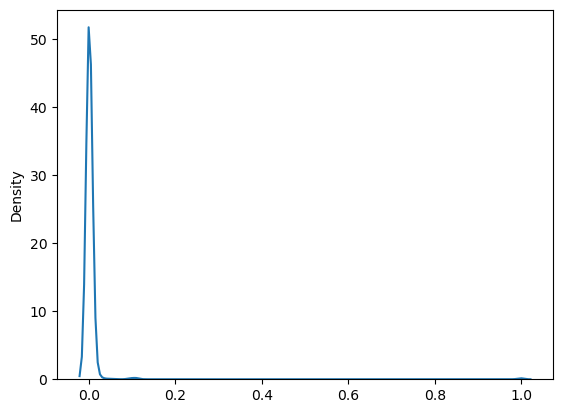

In [26]:
X_opt = torch.sigmoid(Z).detach().numpy()
sns.kdeplot(X_opt)

(9, 111)


<Axes: >

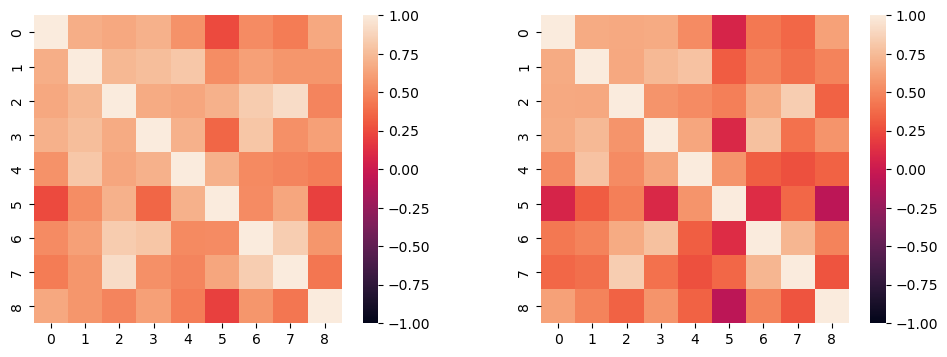

In [27]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(target_corr_mat, ax=ax1, square=True, vmin=-1, vmax=1)
B = raw_counts[:, X_opt > 0.5]
print(B.shape)
result = np.corrcoef(B)
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(result, ax=ax2, square=True, vmin=-1, vmax=1)

In [28]:
target_corr_mat = np.array([
    [1,0.860763708265697,0.457231200932396,0.930439146792128,0.699136302291983,0.564600253149548,0.813743762445643,0.678540663328645,0.666971138399182],
    [0.860763708265697,1,0.808123995334152,0.98025031560194,0.951116464772272,0.867488335472885,0.916674750511615,0.838895466762595,0.917214852363246],
    [0.457231200932396,0.808123995334152,1,0.73281818085952,0.937003503258797,0.990266060786418,0.846025804584184,0.884471439467938,0.959546577442205],
    [0.930439146792128,0.98025031560194,0.73281818085952,1,0.90634795499483,0.811082592644863,0.934938217314636,0.836011456175919,0.880918209339904],
    [0.699136302291983,0.951116464772272,0.937003503258797,0.90634795499483,1,0.968956298078889,0.933096947201883,0.919539967867016,0.973776439354884],
    [0.564600253149548,0.867488335472885,0.990266060786418,0.811082592644863,0.968956298078889,1,0.908030684025974,0.927296966372622,0.983725515226248],
    [0.813743762445643,0.916674750511615,0.846025804584184,0.934938217314636,0.933096947201883,0.908030684025974,1,0.9668486955116,0.938786014000433],
    [0.678540663328645,0.838895466762595,0.884471439467938,0.836011456175919,0.919539967867016,0.927296966372622,0.9668486955116,1,0.914295847455825],
    [0.666971138399182,0.917214852363246,0.959546577442205,0.880918209339904,0.973776439354884,0.983725515226248,0.938786014000433,0.914295847455825,1],
])

In [29]:
Z = torch.randn(raw_counts.shape[1], requires_grad=True)
optimizer = torch.optim.Adam([Z], lr=0.01)

def loss_fn(Z, A, T_target):
    X = torch.sigmoid(Z)
    B = A * X
    T_B = torch.corrcoef(B)
    return torch.norm(T_B - T_target, "fro")
for i in range(20000):
    optimizer.zero_grad()
    loss = loss_fn(
        Z, 
        torch.tensor(raw_counts, dtype=torch.float32), 
        torch.tensor(target_corr_mat, dtype=torch.float32)
    )
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 1.4851900339126587
Iteration 1000, Loss: 0.5495375990867615
Iteration 2000, Loss: 0.340387761592865
Iteration 3000, Loss: 0.21690312027931213
Iteration 4000, Loss: 0.1392071694135666
Iteration 5000, Loss: 0.11435357481241226
Iteration 6000, Loss: 0.10779350996017456
Iteration 7000, Loss: 0.09246252477169037
Iteration 8000, Loss: 0.051290981471538544
Iteration 9000, Loss: 0.04492589831352234
Iteration 10000, Loss: 0.041685983538627625
Iteration 11000, Loss: 0.03997074067592621
Iteration 12000, Loss: 0.037580933421850204
Iteration 13000, Loss: 0.03532262519001961
Iteration 14000, Loss: 0.03300025314092636
Iteration 15000, Loss: 0.03272899240255356
Iteration 16000, Loss: 0.03240429610013962
Iteration 17000, Loss: 0.03239401802420616
Iteration 18000, Loss: 0.03238917887210846
Iteration 19000, Loss: 0.03233968839049339


(9, 111)


<Axes: >

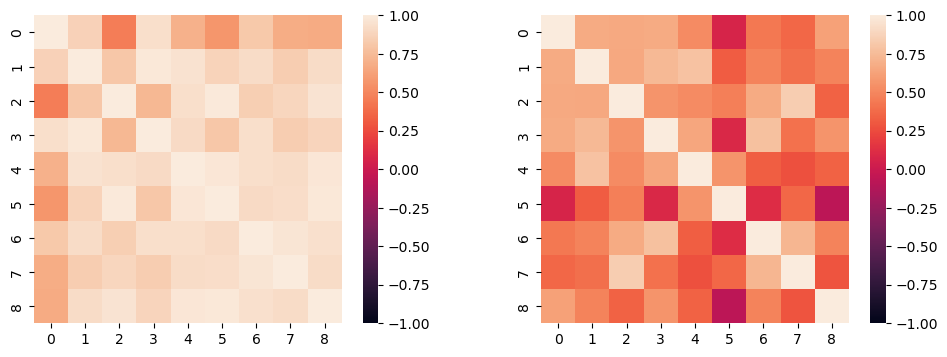

In [30]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(target_corr_mat, ax=ax1, square=True, vmin=-1, vmax=1)
B = raw_counts[:, X_opt > 0.5]
print(B.shape)
result = np.corrcoef(B)
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(result, ax=ax2, square=True, vmin=-1, vmax=1)

<Axes: ylabel='Density'>

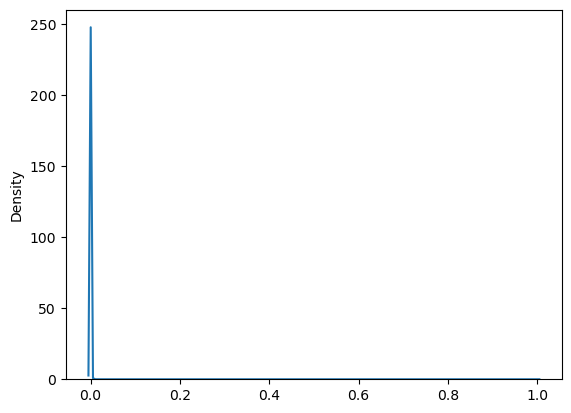

In [31]:
X_opt = torch.sigmoid(Z).detach().numpy()
sns.kdeplot(X_opt)

## Oligo

In [17]:
celltype = "Oligo"
rna_counts = sc.read_h5ad(f"{celltype}_rna_matrix.h5ad")
if rna_counts.raw is not None:
    rna_counts = rna_counts.raw.to_adata()
rna_region_counts = dc.get_pseudobulk(
    adata=rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(rna_region_counts, target_sum=1e6)
sc.pp.log1p(rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
raw_counts = rna_region_counts[region_align, :].X.copy()

/tscc/nfs/home/biy022/miniconda3/envs/finemo/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
target_corr_mat = np.array([
    [1,0.236257917694611,0.880302971831144,0.380834716566659,0.631145212955378,0.58961017838886,0.543407056866351,0.917524042254711,0.497484347212762],
    [0.236257917694611,1,0.50271480525567,0.772857369291718,0.585037002866938,0.360339063340828,0.782226628382098,0.282464238745613,0.35143941088817],
    [0.880302971831144,0.50271480525567,1,0.527573574505212,0.802460737332914,0.671412053826352,0.712989330749817,0.852447624306027,0.663256206549299],
    [0.380834716566659,0.772857369291718,0.527573574505212,1,0.607749448853295,0.563882427130964,0.612974888031381,0.360002232766165,0.485220547458461],
    [0.631145212955378,0.585037002866938,0.802460737332914,0.607749448853295,1,0.660290255210335,0.591970208565646,0.622727521362529,0.767293497371046],
    [0.58961017838886,0.360339063340828,0.671412053826352,0.563882427130964,0.660290255210335,1,0.44644041174587,0.61032674422284,0.544191390751087],
    [0.543407056866351,0.782226628382098,0.712989330749817,0.612974888031381,0.591970208565646,0.44644041174587,1,0.629916227390883,0.538411322324827],
    [0.917524042254711,0.282464238745613,0.852447624306027,0.360002232766165,0.622727521362529,0.61032674422284,0.629916227390883,1,0.564184345165232],
    [0.497484347212762,0.35143941088817,0.663256206549299,0.485220547458461,0.767293497371046,0.544191390751087,0.538411322324827,0.564184345165232,1],
])

In [19]:
Z = torch.randn(raw_counts.shape[1], requires_grad=True)
optimizer = torch.optim.Adam([Z], lr=0.01)

def loss_fn(Z, A, T_target):
    X = torch.sigmoid(Z)
    B = A * X
    T_B = torch.corrcoef(B)
    return torch.norm(T_B - T_target, "fro")
for i in range(20000):
    optimizer.zero_grad()
    loss = loss_fn(
        Z, 
        torch.tensor(raw_counts, dtype=torch.float32), 
        torch.tensor(target_corr_mat, dtype=torch.float32)
    )
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 3.7391881942749023
Iteration 1000, Loss: 1.6433041095733643
Iteration 2000, Loss: 0.7720240354537964
Iteration 3000, Loss: 0.49316081404685974
Iteration 4000, Loss: 0.30816808342933655
Iteration 5000, Loss: 0.13392993807792664
Iteration 6000, Loss: 0.05816403031349182
Iteration 7000, Loss: 0.027004504576325417
Iteration 8000, Loss: 0.005044469144195318
Iteration 9000, Loss: 0.0002867321309167892
Iteration 10000, Loss: 0.00011908078886335716
Iteration 11000, Loss: 9.314732596976683e-05
Iteration 12000, Loss: 0.00019890206749550998
Iteration 13000, Loss: 0.00017929403111338615
Iteration 14000, Loss: 0.0001815981522668153
Iteration 15000, Loss: 0.0001789187517715618
Iteration 16000, Loss: 0.0001798363809939474
Iteration 17000, Loss: 0.00017815032333601266
Iteration 18000, Loss: 0.00017981405835598707
Iteration 19000, Loss: 0.00018104669288732111


<Axes: ylabel='Density'>

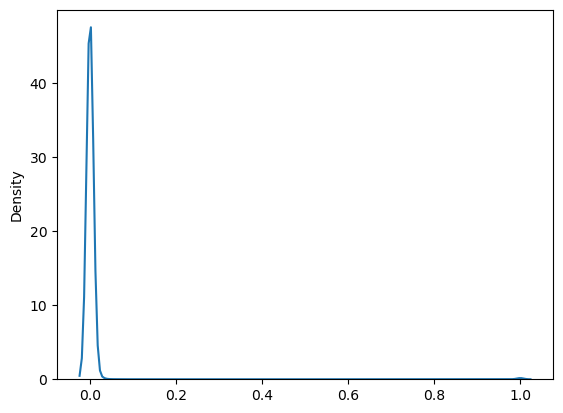

In [20]:
X_opt = torch.sigmoid(Z).detach().numpy()
sns.kdeplot(X_opt)

(9, 137)


<Axes: >

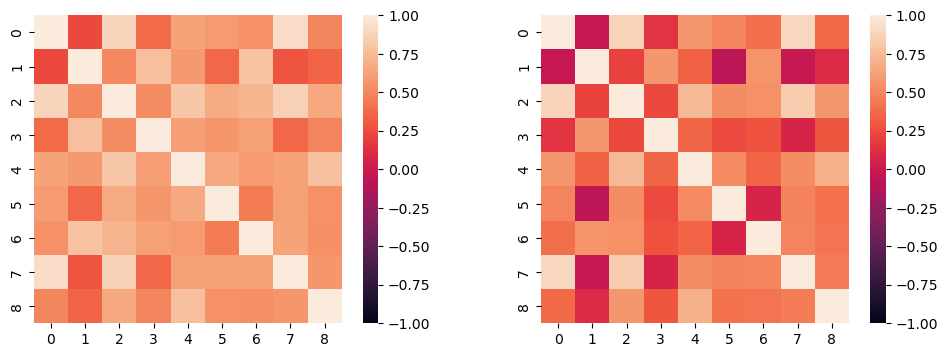

In [21]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(target_corr_mat, ax=ax1, square=True, vmin=-1, vmax=1)
B = raw_counts[:, X_opt > 0.5]
print(B.shape)
result = np.corrcoef(B)
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(result, ax=ax2, square=True, vmin=-1, vmax=1)

## "Permutation" test

In [50]:
celltype = "L2_3_IT"
rna_counts = sc.read_h5ad(f"{celltype}_rna_matrix.h5ad")
if rna_counts.raw is not None:
    rna_counts = rna_counts.raw.to_adata()
rna_region_counts = dc.get_pseudobulk(
    adata=rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(rna_region_counts, target_sum=1e6)
sc.pp.log1p(rna_region_counts, base=2)
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
raw_counts = rna_region_counts[region_align, :].X.copy()

/tscc/nfs/home/biy022/miniconda3/envs/finemo/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [51]:
target_corr_mat = np.array([
    [1,0.883044099843332,0.721459183061701,0.794715927961463,0.748747081206719,0.66939771544504,0.775686190271696,0.835702552081961,0.760135291239455],
    [0.883044099843332,1,0.83072965561328,0.805715037781131,0.636545620241836,0.776517952079455,0.713573159850172,0.899102921973653,0.778714927840962],
    [0.721459183061701,0.83072965561328,1,0.732409649857523,0.675138071197081,0.87430763927178,0.742967408449887,0.923372849427871,0.740664787587536],
    [0.794715927961463,0.805715037781131,0.732409649857523,1,0.711107568676242,0.641480156224853,0.873566560308273,0.803930074046558,0.91846502565562],
    [0.748747081206719,0.636545620241836,0.675138071197081,0.711107568676242,1,0.545456879024877,0.783784377609343,0.675942169682257,0.698234662761269],
    [0.66939771544504,0.776517952079455,0.87430763927178,0.641480156224853,0.545456879024877,1,0.65487507848436,0.892399711810839,0.641712626390082],
    [0.775686190271696,0.713573159850172,0.742967408449887,0.873566560308273,0.783784377609343,0.65487507848436,1,0.826003615317594,0.882406629707588],
    [0.835702552081961,0.899102921973653,0.923372849427871,0.803930074046558,0.675942169682257,0.892399711810839,0.826003615317594,1,0.802201770116069],
    [0.760135291239455,0.778714927840962,0.740664787587536,0.91846502565562,0.698234662761269,0.641712626390082,0.882406629707588,0.802201770116069,1],
])

In [52]:
Z = torch.randn(raw_counts.shape[1], requires_grad=True)
optimizer = torch.optim.Adam([Z], lr=0.01)

def loss_fn(Z, A, T_target):
    X = torch.sigmoid(Z)
    B = A * X
    T_B = torch.corrcoef(B)
    return torch.norm(T_B - T_target, "fro")
for i in range(10000):
    optimizer.zero_grad()
    loss = loss_fn(
        Z, 
        torch.tensor(raw_counts, dtype=torch.float32), 
        torch.tensor(target_corr_mat, dtype=torch.float32)
    )
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 2.065695285797119
Iteration 1000, Loss: 0.6504333019256592
Iteration 2000, Loss: 0.34459051489830017
Iteration 3000, Loss: 0.2331613451242447
Iteration 4000, Loss: 0.14945296943187714
Iteration 5000, Loss: 0.10035217553377151
Iteration 6000, Loss: 0.07825947552919388
Iteration 7000, Loss: 0.04078621044754982
Iteration 8000, Loss: 0.008487528190016747
Iteration 9000, Loss: 0.000441752839833498


<Axes: ylabel='Density'>

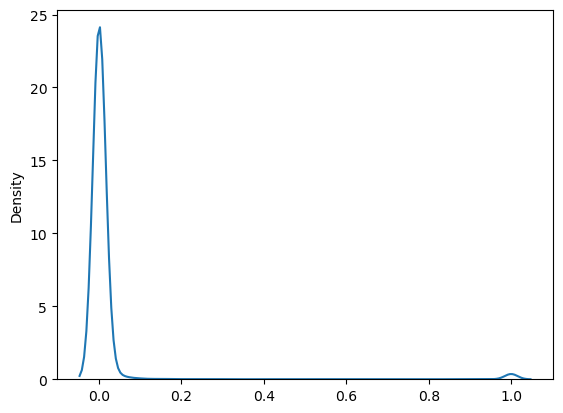

In [53]:
X_opt = torch.sigmoid(Z).detach().numpy()
sns.kdeplot(X_opt)

(9, 474)


<Axes: >

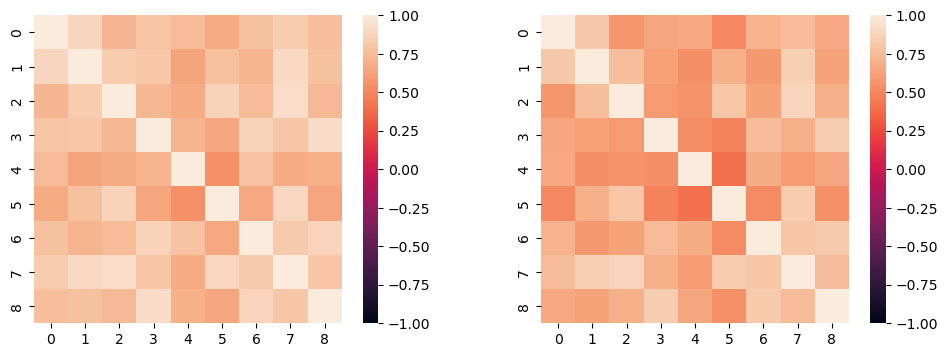

In [54]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, figure = fig)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(target_corr_mat, ax=ax1, square=True, vmin=-1, vmax=1)
B = raw_counts[:, X_opt > 0.9]
print(B.shape)
result = np.corrcoef(B)
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(result, ax=ax2, square=True, vmin=-1, vmax=1)

In [27]:
def shuffle_symmetric_matrix(m):
    n = m.shape[0]
    iu = np.triu_indices(n, k=1)
    iu_values = m[iu]
    np.random.shuffle(iu_values)
    result = np.zeros_like(m)
    result[iu] = iu_values
    result += result.T
    np.fill_diagonal(result, np.diagonal(m))
    return result

In [32]:
n_genes = list()
iter_loss = list()

In [33]:
for i in range(0, 1000):
    if i % 100 == 0:
        print(f"Iteration {i} started...")
    Z = torch.randn(raw_counts.shape[1], requires_grad=True)
    optimizer = torch.optim.Adam([Z], lr=0.01)
    
    def loss_fn(Z, A, T_target):
        X = torch.sigmoid(Z)
        B = A * X
        T_B = torch.corrcoef(B)
        return torch.norm(T_B - T_target, "fro")
    shuffled_mat = shuffle_symmetric_matrix(target_corr_mat)
    for k in range(10000):
        optimizer.zero_grad()
        loss = loss_fn(
            Z, 
            torch.tensor(raw_counts, dtype=torch.float32), 
            torch.tensor(shuffled_mat, dtype=torch.float32)
        )
        loss.backward()
        optimizer.step()
    X_opt = torch.sigmoid(Z).detach().numpy()
    n_genes.append(sum(X_opt > 0.9))
    iter_loss.append(loss.item())

Iteration 0 started...
Iteration 100 started...
Iteration 200 started...
Iteration 300 started...
Iteration 400 started...
Iteration 500 started...
Iteration 600 started...
Iteration 700 started...
Iteration 800 started...
Iteration 900 started...


<Axes: ylabel='Count'>

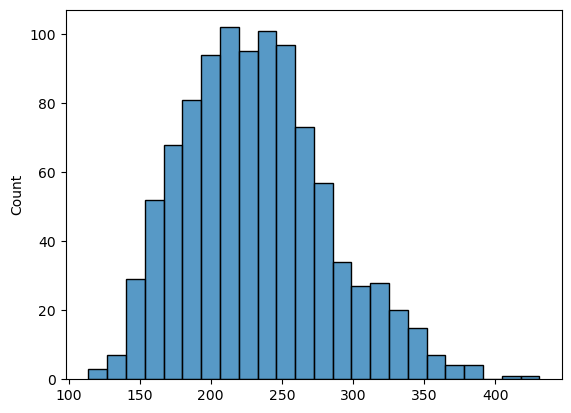

In [34]:
sns.histplot(n_genes)

<Axes: ylabel='Count'>

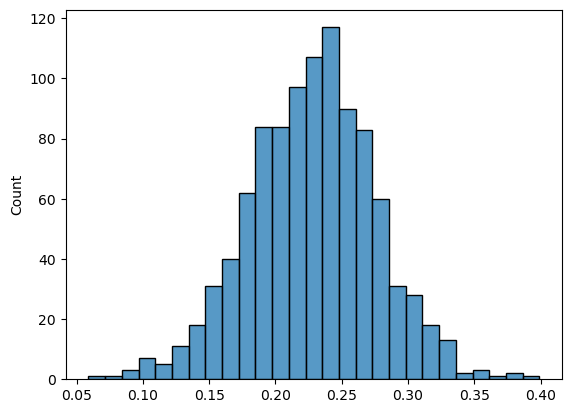

In [35]:
sns.histplot(iter_loss)

In [55]:
import pickle

In [38]:
result = dict()
result["n_genes"] = n_genes
result["iter_loss"] = iter_loss
with open("../L2_3_IT/torch_results/L2_3_IT_1000_result.pk", "wb") as f:
    pickle.dump(result, f)

In [56]:
with open("../L2_3_IT/torch_results/L2_3_IT_1000_result.pk", "rb") as f:
    result = pickle.load(f)

In [61]:
target_loss = loss.item()
target_n = B.shape[1]

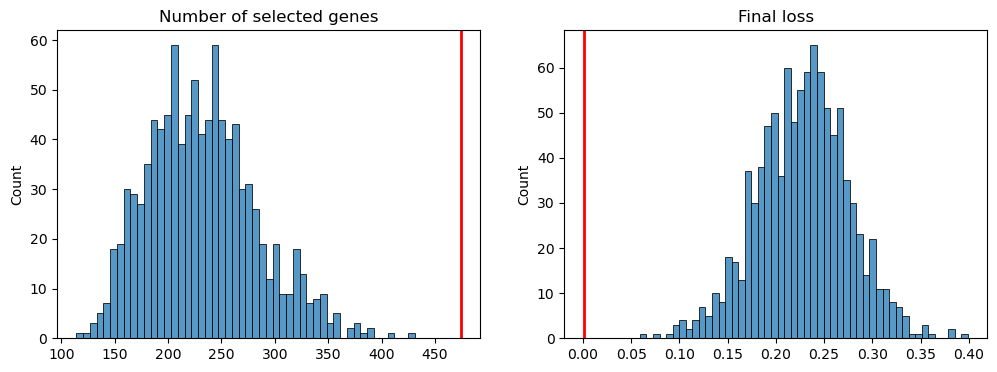

In [65]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(result["n_genes"], bins=50, ax=ax1)
ax1.axvline(x=target_n, color="red", linewidth=2)
ax1.set_title("Number of selected genes")
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(result["iter_loss"], bins=50, ax=ax2)
ax2.axvline(x=target_loss, color="red", linewidth=2)
ax2.set_title("Final loss")
fig.savefig("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_figures/L2_3_IT_matching_spatial_rna_torch.pdf", dpi=250)